# Geospatial Enrichment of the Housing Dataset

This notebook adds geospatial context to the cleaned California housing dataset. Using latitude and longitude coordinates, we integrate geographic boundary data for California counties. We will follow these steps:

- Load cleaned data and geospatial boundary files
- Convert the dataset into a GeoDataFrame
- Set the proper coordinate reference systems (CRS)
- Join housing data with county boundaries
- Compute county-level aggregations and explore spatial patterns

The final dataset will allow for geographic visualizations and location-aware modeling.


## Initial Setup

We start by enabling module autoreloading and importing libraries needed for geospatial data handling, plotting, and data transformation.


In [ ]:
%load_ext autoreload
%autoreload 2

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

from california.config import INTERIM_DATA_FILE
from california.config import GEO_CALIFORNIA_COUNTIES_FILE, GEO_MEDIAN_DF_FILE
from california.plots import plot_county_map
from california.utils import nearest_county



Here we verify the structure, types, and memory usage of the loaded DataFrame. This confirms successful import and helps check for optimization opportunities.


In [2]:
df = pd.read_parquet(INTERIM_DATA_FILE)

df.head()

,latitude,longitude,housing_median_age,total_rooms,population,median_income,rooms_per_household,population_per_household,bedrooms_per_room,ocean_proximity,median_income_cat,median_house_value
0,37.88,-122.23,41,880,322,8.3252,6.984127,2.555556,0.146591,NEAR BAY,1,452600
1,37.84,-122.26,42,2555,1206,2.0804,4.294118,2.026891,0.260274,NEAR BAY,2,226700
2,37.85,-122.26,50,1120,697,2.1250,4.242424,2.640152,0.252679,NEAR BAY,2,140000
3,37.84,-122.26,50,2239,990,1.9911,5.343675,2.362768,0.203216,NEAR BAY,2,158700
4,37.85,-122.27,40,751,409,1.3578,4.524096,2.463855,0.245007,NEAR BAY,2,147500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17889 entries, 0 to 17888
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   latitude                  17889 non-null  float64 
 1   longitude                 17889 non-null  float64 
 2   housing_median_age        17889 non-null  int8    
 3   total_rooms               17889 non-null  int16   
 4   population                17889 non-null  int16   
 5   median_income             17889 non-null  float64 
 6   rooms_per_household       17889 non-null  float64 
 7   population_per_household  17889 non-null  float64 
 8   bedrooms_per_room         17889 non-null  float64 
 9   ocean_proximity           17889 non-null  category
 10  median_income_cat         17889 non-null  int32   
 11  median_house_value        17889 non-null  int32   
dtypes: category(1), float64(6), int16(2), int32(2), int8(1)
memory usage: 1.1 MB


In [4]:
# median_income_cat as categorical
df['median_income_cat'] = df['median_income_cat'].astype('category')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17889 entries, 0 to 17888
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   latitude                  17889 non-null  float64 
 1   longitude                 17889 non-null  float64 
 2   housing_median_age        17889 non-null  int8    
 3   total_rooms               17889 non-null  int16   
 4   population                17889 non-null  int16   
 5   median_income             17889 non-null  float64 
 6   rooms_per_household       17889 non-null  float64 
 7   population_per_household  17889 non-null  float64 
 8   bedrooms_per_room         17889 non-null  float64 
 9   ocean_proximity           17889 non-null  category
 10  median_income_cat         17889 non-null  category
 11  median_house_value        17889 non-null  int32   
dtypes: category(2), float64(6), int16(2), int32(1), int8(1)
memory usage: 1.0 MB



We import a GeoJSON containing the polygonal boundaries of California counties. This will be used to map and join spatial data.


In [6]:
gdf_counties = gpd.read_file(GEO_CALIFORNIA_COUNTIES_FILE)
gdf_counties.head()

,name,fullname,abbrev,abcode,ansi,geometry
0,Siskiyou,Siskiyou County,SIS,c047,093,"POLYGON ((-121.44597 41.1839, -121.46238 41.18..."
1,Del Norte,Del Norte County,DNT,c008,015,"MULTIPOLYGON (((-124.19097 41.73619, -124.1933..."
2,Modoc,Modoc County,MOD,c025,049,"POLYGON ((-121.44784 41.99739, -121.42322 41.9..."
3,Trinity,Trinity County,TRI,c053,105,"POLYGON ((-122.66795 40.77637, -122.66814 40.7..."
4,Shasta,Shasta County,SHA,c045,089,"POLYGON ((-122.17328 40.37906, -122.17359 40.3..."



This step plots the California county geometries to ensure the spatial file was read and parsed correctly.


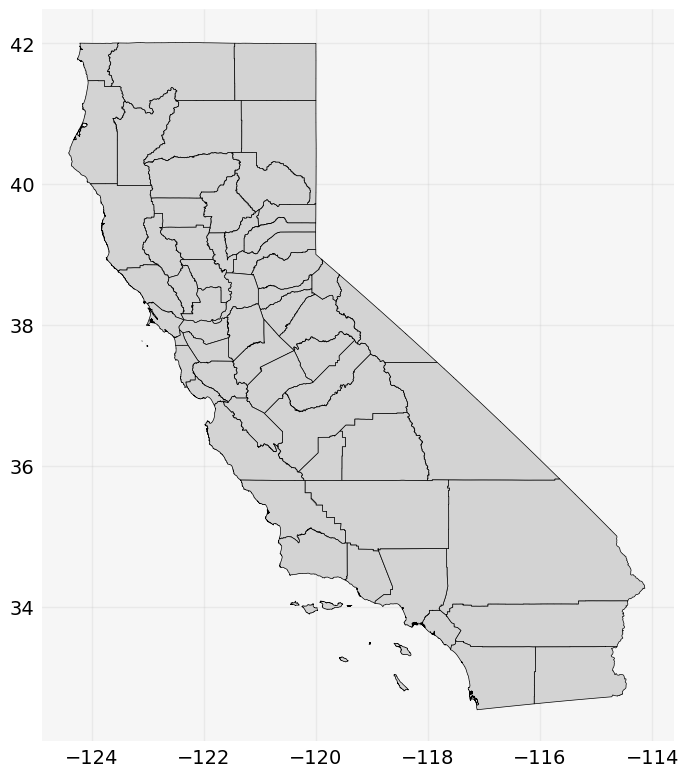

In [7]:
plot_county_map(gdf_counties)


We convert each row's `(longitude, latitude)` into Shapely `Point` objects. This is required to transform the standard DataFrame into a GeoDataFrame.


In [8]:
points = [Point(long, lat) for long, lat in zip(df["longitude"], df["latitude"])]

points[:5]

[<POINT (-122.23 37.88)>,
 <POINT (-122.26 37.84)>,
 <POINT (-122.26 37.85)>,
 <POINT (-122.26 37.84)>,
 <POINT (-122.27 37.85)>]


We construct a GeoDataFrame from the cleaned housing data, assigning geometry based on the previously created points.


In [9]:
gdf = gpd.GeoDataFrame(df, geometry=points)
gdf.head()

,latitude,longitude,housing_median_age,total_rooms,population,median_income,rooms_per_household,population_per_household,bedrooms_per_room,ocean_proximity,median_income_cat,median_house_value,geometry
0,37.88,-122.23,41,880,322,8.3252,6.984127,2.555556,0.146591,NEAR BAY,1,452600,POINT (-122.23 37.88)
1,37.84,-122.26,42,2555,1206,2.0804,4.294118,2.026891,0.260274,NEAR BAY,2,226700,POINT (-122.26 37.84)
2,37.85,-122.26,50,1120,697,2.1250,4.242424,2.640152,0.252679,NEAR BAY,2,140000,POINT (-122.26 37.85)
3,37.84,-122.26,50,2239,990,1.9911,5.343675,2.362768,0.203216,NEAR BAY,2,158700,POINT (-122.26 37.84)
4,37.85,-122.27,40,751,409,1.3578,4.524096,2.463855,0.245007,NEAR BAY,2,147500,POINT (-122.27 37.85)


In [10]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17889 entries, 0 to 17888
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   latitude                  17889 non-null  float64 
 1   longitude                 17889 non-null  float64 
 2   housing_median_age        17889 non-null  int8    
 3   total_rooms               17889 non-null  int16   
 4   population                17889 non-null  int16   
 5   median_income             17889 non-null  float64 
 6   rooms_per_household       17889 non-null  float64 
 7   population_per_household  17889 non-null  float64 
 8   bedrooms_per_room         17889 non-null  float64 
 9   ocean_proximity           17889 non-null  category
 10  median_income_cat         17889 non-null  category
 11  median_house_value        17889 non-null  int32   
 12  geometry                  17889 non-null  geometry
dtypes: category(2), float64(6), geometry(1

## Set Coordinate Reference System (CRS)

We explicitly set the CRS to WGS84 (`EPSG:4326`) to ensure consistency before spatial joins. This is standard for geographic coordinates.


In [11]:
gdf.crs

In [12]:
gdf_counties.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
gdf = gdf.set_crs(epsg=4326)

gdf_counties = gdf_counties.to_crs(epsg=4326)


We compute the centroid of each county polygon, which may be used for nearest-county logic or label placement in maps.


In [14]:
gdf_counties["centroid"] = gdf_counties.centroid

/tmp/ipykernel_1163368/246098032.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_counties["centroid"] = gdf_counties.centroid



We perform a spatial join between the housing point data and county polygons to assign each house to its respective county.


In [15]:
gdf_joined = gpd.sjoin(gdf, gdf_counties, how="left", predicate="within")

gdf_joined.head()

,latitude,longitude,housing_median_age,total_rooms,population,median_income,rooms_per_household,population_per_household,bedrooms_per_room,ocean_proximity,median_income_cat,median_house_value,geometry,index_right,name,fullname,abbrev,abcode,ansi,centroid
0,37.88,-122.23,41,880,322,8.3252,6.984127,2.555556,0.146591,NEAR BAY,1,452600,POINT (-122.23 37.88),34.0,Alameda,Alameda County,ALA,c001,001,POINT (-121.91809 37.65045)
1,37.84,-122.26,42,2555,1206,2.0804,4.294118,2.026891,0.260274,NEAR BAY,2,226700,POINT (-122.26 37.84),34.0,Alameda,Alameda County,ALA,c001,001,POINT (-121.91809 37.65045)
2,37.85,-122.26,50,1120,697,2.1250,4.242424,2.640152,0.252679,NEAR BAY,2,140000,POINT (-122.26 37.85),34.0,Alameda,Alameda County,ALA,c001,001,POINT (-121.91809 37.65045)
3,37.84,-122.26,50,2239,990,1.9911,5.343675,2.362768,0.203216,NEAR BAY,2,158700,POINT (-122.26 37.84),34.0,Alameda,Alameda County,ALA,c001,001,POINT (-121.91809 37.65045)
4,37.85,-122.27,40,751,409,1.3578,4.524096,2.463855,0.245007,NEAR BAY,2,147500,POINT (-122.27 37.85),34.0,Alameda,Alameda County,ALA,c001,001,POINT (-121.91809 37.65045)


In [16]:
gdf_joined = gdf_joined.drop(
    columns=["index_right", "fullname", "abcode", "ansi"]
)

gdf_joined.head()

,latitude,longitude,housing_median_age,total_rooms,population,median_income,rooms_per_household,population_per_household,bedrooms_per_room,ocean_proximity,median_income_cat,median_house_value,geometry,name,abbrev,centroid
0,37.88,-122.23,41,880,322,8.3252,6.984127,2.555556,0.146591,NEAR BAY,1,452600,POINT (-122.23 37.88),Alameda,ALA,POINT (-121.91809 37.65045)
1,37.84,-122.26,42,2555,1206,2.0804,4.294118,2.026891,0.260274,NEAR BAY,2,226700,POINT (-122.26 37.84),Alameda,ALA,POINT (-121.91809 37.65045)
2,37.85,-122.26,50,1120,697,2.1250,4.242424,2.640152,0.252679,NEAR BAY,2,140000,POINT (-122.26 37.85),Alameda,ALA,POINT (-121.91809 37.65045)
3,37.84,-122.26,50,2239,990,1.9911,5.343675,2.362768,0.203216,NEAR BAY,2,158700,POINT (-122.26 37.84),Alameda,ALA,POINT (-121.91809 37.65045)
4,37.85,-122.27,40,751,409,1.3578,4.524096,2.463855,0.245007,NEAR BAY,2,147500,POINT (-122.27 37.85),Alameda,ALA,POINT (-121.91809 37.65045)


In [17]:
gdf_joined.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 17889 entries, 0 to 17888
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   latitude                  17889 non-null  float64 
 1   longitude                 17889 non-null  float64 
 2   housing_median_age        17889 non-null  int8    
 3   total_rooms               17889 non-null  int16   
 4   population                17889 non-null  int16   
 5   median_income             17889 non-null  float64 
 6   rooms_per_household       17889 non-null  float64 
 7   population_per_household  17889 non-null  float64 
 8   bedrooms_per_room         17889 non-null  float64 
 9   ocean_proximity           17889 non-null  category
 10  median_income_cat         17889 non-null  category
 11  median_house_value        17889 non-null  int32   
 12  geometry                  17889 non-null  geometry
 13  name                      17739 non-null  o

In [18]:
gdf_joined.isnull().sum()

latitude                      0
longitude                     0
housing_median_age            0
total_rooms                   0
population                    0
median_income                 0
rooms_per_household           0
population_per_household      0
bedrooms_per_room             0
ocean_proximity               0
median_income_cat             0
median_house_value            0
geometry                      0
name                        150
abbrev                      150
centroid                    150
dtype: int64


Let's check for nulls in the joined dataset to identify any records that might not have matched properly during the spatial join. And fill the null values with the nearest county's name. This ensures that all housing records have a valid county association.

In [19]:
rows_with_nulls = gdf_joined[gdf_joined.isnull().any(axis=1)].index
rows_with_nulls

Index([ 1487,  1488,  1491,  1497,  1502,  2160,  2200,  2208,  2210,  2226,
       ...
       16061, 16062, 16063, 16693, 17517, 17518, 17520, 17553, 17575, 17580],
      dtype='int64', length=150)

In [ ]:
gdf_joined.loc[rows_with_nulls, ["name", "abbrev"]] = gdf_joined.loc[
    rows_with_nulls
].apply(nearest_county, geodf=gdf_joined, axis=1)

In [21]:
gdf_joined.isnull().sum()

latitude                      0
longitude                     0
housing_median_age            0
total_rooms                   0
population                    0
median_income                 0
rooms_per_household           0
population_per_household      0
bedrooms_per_room             0
ocean_proximity               0
median_income_cat             0
median_house_value            0
geometry                      0
name                          0
abbrev                        0
centroid                    150
dtype: int64

In [22]:
gdf_joined["name"].value_counts()

name
Los Angeles        4980
Orange             1480
San Diego          1457
Santa Clara         832
San Bernardino      766
Alameda             726
Sacramento          619
Contra Costa        540
Riverside           509
Fresno              498
San Joaquin         395
Kern                352
Ventura             346
San Mateo           331
Sonoma              292
Stanislaus          281
Santa Barbara       265
Tulare              252
San Francisco       213
Santa Cruz          189
Solano              173
Monterey            168
Butte               143
San Luis Obispo     130
Placer              125
Merced              124
Imperial            119
Shasta              119
El Dorado           118
Marin               115
Humboldt            110
Napa                 94
Nevada               90
Kings                86
Lake                 86
Mendocino            77
Madera               75
Yolo                 75
Sutter               56
Tuolumne             53
Yuba                 51
Tehama     

Now, we can visualize the data points on a map.

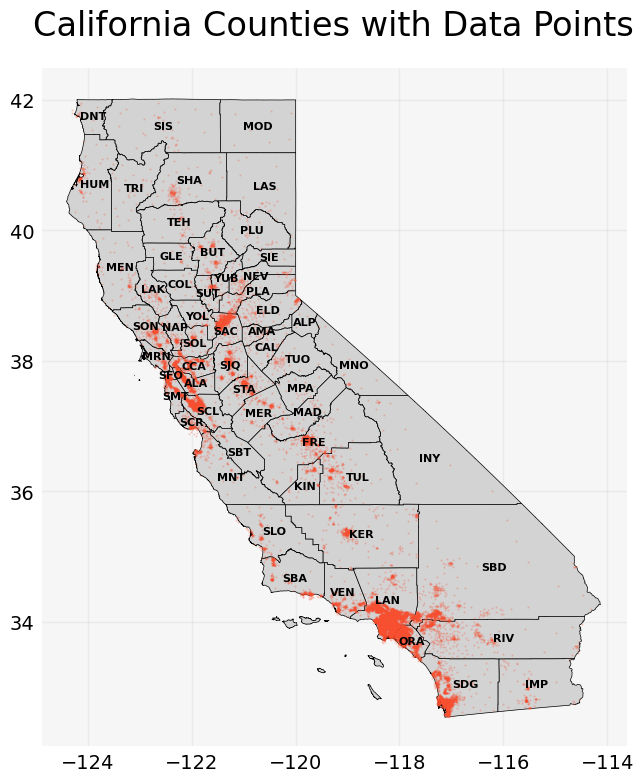

In [23]:
plot_county_map(
    gdf_counties,
    gdf_joined,
    show_scatter=True,
    show_abbrev=True,
    fig_title="California Counties with Data Points",
)

More than the points themselves, it would be useful to visualize the numeric and categorical data associated with each point. For example, we can visualize the average house value per county. So let's aggregate the data by county and check which category is the most common in each county for each categorical column.

In [24]:
gdf_joined.groupby("name").median(numeric_only=True)

,latitude,longitude,housing_median_age,total_rooms,population,median_income,rooms_per_household,population_per_household,bedrooms_per_room,median_house_value
name,,,,,,,,,,
Alameda,37.710,-122.140,35.0,1897.5,1022.5,3.53040,5.069423,2.717550,0.207932,187500.0
Alpine,38.705,-119.935,16.5,1756.0,402.5,2.34585,9.744495,2.102038,0.216182,129100.0
Amador,38.425,-120.720,17.0,1785.0,786.5,3.08575,6.074708,2.442094,0.191623,117600.0
Butte,39.710,-121.600,22.0,1852.0,925.0,2.31550,5.302041,2.510086,0.200000,86400.0
Calaveras,38.235,-120.545,16.0,2964.5,960.5,2.68045,6.079977,2.457632,0.201661,106150.0
Colusa,39.180,-122.045,34.0,1497.0,665.0,2.50920,5.468055,2.895284,0.204971,68950.0
Contra Costa,37.950,-122.060,28.0,2336.5,1109.0,4.34165,5.677059,2.733673,0.184961,184000.0
Del Norte,41.770,-124.170,19.0,2715.0,1298.0,2.27500,5.589958,2.728070,0.206587,78300.0
El Dorado,38.805,-120.625,17.0,2221.0,859.5,3.19165,6.319238,2.649850,0.196192,128250.0


In [25]:
gdf_counties_median = gdf_counties.merge(
    gdf_joined.groupby("name").median(numeric_only=True),
    left_on="name",
    right_index=True,
)

gdf_counties_median.head()

,name,fullname,abbrev,abcode,ansi,geometry,centroid,latitude,longitude,housing_median_age,total_rooms,population,median_income,rooms_per_household,population_per_household,bedrooms_per_room,median_house_value
0,Siskiyou,Siskiyou County,SIS,c047,093,"POLYGON ((-121.44597 41.1839, -121.46238 41.18...",POINT (-122.54047 41.59268),41.60,-122.53,23.0,2344.0,1109.0,2.1607,5.915408,2.514151,0.201967,63300.0
1,Del Norte,Del Norte County,DNT,c008,015,"MULTIPOLYGON (((-124.19097 41.73619, -124.1933...",POINT (-123.89681 41.74299),41.77,-124.17,19.0,2715.0,1298.0,2.2750,5.589958,2.728070,0.206587,78300.0
2,Modoc,Modoc County,MOD,c025,049,"POLYGON ((-121.44784 41.99739, -121.42322 41.9...",POINT (-120.72517 41.58987),41.54,-120.51,22.0,2124.0,829.0,2.2321,6.997519,2.438202,0.197395,52600.0
3,Trinity,Trinity County,TRI,c053,105,"POLYGON ((-122.66795 40.77637, -122.66814 40.7...",POINT (-123.11264 40.65063),40.61,-123.17,19.0,817.0,316.0,1.9034,6.190083,2.516854,0.229498,73700.0
4,Shasta,Shasta County,SHA,c045,089,"POLYGON ((-122.17328 40.37906, -122.17359 40.3...",POINT (-122.04016 40.76344),40.57,-122.35,19.0,2251.0,1077.0,2.4079,5.487129,2.714097,0.198684,85200.0


In [26]:
gdf_joined[["name", "ocean_proximity"]].groupby("name").describe()

ocean_proximity                         
                          count unique         top  freq
name                                                    
Alameda                     726      3    NEAR BAY   611
Alpine                        4      1      INLAND     4
Amador                       28      1      INLAND    28
Butte                       143      1      INLAND   143
Calaveras                    32      1      INLAND    32
Colusa                       14      1      INLAND    14
Contra Costa                540      3    NEAR BAY   361
Del Norte                    17      2  NEAR OCEAN    15
El Dorado                   118      1      INLAND   118
Fresno                      498      1      INLAND   498
Glenn                        26      1      INLAND    26
Humboldt                    110      3  NEAR OCEAN    79
Imperial                    119      1      INLAND   119
Inyo                         18      1      INLAND    18
Kern                        352      1      INLAND   352
Kings                        86      1      INLAND    86
Lake                         86      2      INLAND    80
Lassen                       22      1      INLAND    22
Los Angeles                4980      3   <1H OCEAN  4330
Madera                       75      1      INLAND    75
Marin                       115      3    NEAR BAY    88
Mariposa                     18      1      INLAND    18
Mendocino                    77      3   <1H OCEAN    61
Merced                      124      1      INLAND   124
Modoc                         7      1      INLAND     7
Mono                         17      1      INLAND    17
Monterey                    168      3   <1H OCEAN   124
Napa                         94      3    NEAR BAY    58
Nevada                       90      1      INLAND    90
Orange                     1480      2   <1H OCEAN  1422
Placer                      125      1      INLAND   125
Plumas                       33      1      INLAND    33
Riverside                   509      2      INLAND   466
Sacramento                  619      1      INLAND   619
San Benito                   26      2      INLAND    25
San Bernardino              766      2      INLAND   762
San Diego                  1457      3  NEAR OCEAN   937
San Francisco               213      2    NEAR BAY   141
San Joaquin                 395      1      INLAND   395
San Luis Obispo             130      3   <1H OCEAN    70
San Mateo                   331      2  NEAR OCEAN   269
Santa Barbara               265      2  NEAR OCEAN   146
Santa Clara                 832      4   <1H OCEAN   732
Santa Cruz                  189      2  NEAR OCEAN   136
Shasta                      119      1      INLAND   119
Sierra                        7      1      INLAND     7
Siskiyou                     35      1      INLAND    35
Solano                      173      2      INLAND   114
Sonoma                      292      3   <1H OCEAN   271
Stanislaus                  281      1      INLAND   281
Sutter                       56      1      INLAND    56
Tehama                       48      1      INLAND    48
Trinity                      27      1      INLAND    27
Tulare                      252      1      INLAND   252
Tuolumne                     53      1      INLAND    53
Ventura                     346      3   <1H OCEAN   192
Yolo                         75      1      INLAND    75
Yuba                         51      1      INLAND    51

In [27]:
county_ocean_prox = (
    gdf_joined[["name", "ocean_proximity"]].groupby("name").agg(pd.Series.mode)
)

county_ocean_prox

,ocean_proximity
name,
Alameda,NEAR BAY
Alpine,INLAND
Amador,INLAND
Butte,INLAND
Calaveras,INLAND
Colusa,INLAND
Contra Costa,NEAR BAY
Del Norte,NEAR OCEAN
El Dorado,INLAND


In [28]:
gdf_counties_median = gdf_counties_median.merge(
    county_ocean_prox,
    left_on="name",
    right_index=True,
)

gdf_counties_median.head()

,name,fullname,abbrev,abcode,ansi,geometry,centroid,latitude,longitude,housing_median_age,total_rooms,population,median_income,rooms_per_household,population_per_household,bedrooms_per_room,median_house_value,ocean_proximity
0,Siskiyou,Siskiyou County,SIS,c047,093,"POLYGON ((-121.44597 41.1839, -121.46238 41.18...",POINT (-122.54047 41.59268),41.60,-122.53,23.0,2344.0,1109.0,2.1607,5.915408,2.514151,0.201967,63300.0,INLAND
1,Del Norte,Del Norte County,DNT,c008,015,"MULTIPOLYGON (((-124.19097 41.73619, -124.1933...",POINT (-123.89681 41.74299),41.77,-124.17,19.0,2715.0,1298.0,2.2750,5.589958,2.728070,0.206587,78300.0,NEAR OCEAN
2,Modoc,Modoc County,MOD,c025,049,"POLYGON ((-121.44784 41.99739, -121.42322 41.9...",POINT (-120.72517 41.58987),41.54,-120.51,22.0,2124.0,829.0,2.2321,6.997519,2.438202,0.197395,52600.0,INLAND
3,Trinity,Trinity County,TRI,c053,105,"POLYGON ((-122.66795 40.77637, -122.66814 40.7...",POINT (-123.11264 40.65063),40.61,-123.17,19.0,817.0,316.0,1.9034,6.190083,2.516854,0.229498,73700.0,INLAND
4,Shasta,Shasta County,SHA,c045,089,"POLYGON ((-122.17328 40.37906, -122.17359 40.3...",POINT (-122.04016 40.76344),40.57,-122.35,19.0,2251.0,1077.0,2.4079,5.487129,2.714097,0.198684,85200.0,INLAND


In [31]:
gdf_joined[["name", "median_income_cat"]].groupby("name").describe()

median_income_cat                 
                            count unique top  freq
name                                              
Alameda                       726      2   2   425
Alpine                          4      1   2     4
Amador                         28      2   2    25
Butte                         143      2   2   142
Calaveras                      32      2   2    31
Colusa                         14      1   2    14
Contra Costa                  540      2   1   309
Del Norte                      17      1   2    17
El Dorado                     118      2   2    95
Fresno                        498      2   3   453
Glenn                          26      1   2    26
Humboldt                      110      2   2   108
Imperial                      119      2   4   106
Inyo                           18      2   3    17
Kern                          352      3   3   266
Kings                          86      1   3    86
Lake                           86      2   2    84
Lassen                         22      2   2    21
Los Angeles                  4980      2   4  3436
Madera                         75      2   3    74
Marin                         115      2   1    81
Mariposa                       18      1   3    18
Mendocino                      77      2   2    75
Merced                        124      3   3    85
Modoc                           7      1   2     7
Mono                           17      2   3    16
Monterey                      168      3   2    73
Napa                           94      2   2    56
Nevada                         90      2   2    79
Orange                       1480      2   0   868
Placer                        125      2   2    82
Plumas                         33      2   2    32
Riverside                     509      2   4   404
Sacramento                    619      2   2   465
San Benito                     26      3   2    13
San Bernardino                766      2   4   574
San Diego                    1457      2   4  1007
San Francisco                 213      2   2   114
San Joaquin                   395      2   2   303
San Luis Obispo               130      2   3   124
San Mateo                     331      2   1   227
Santa Barbara                 265      3   3   181
Santa Clara                   832      2   1   613
Santa Cruz                    189      2   1    97
Shasta                        119      2   2   117
Sierra                          7      1   2     7
Siskiyou                       35      1   2    35
Solano                        173      2   2   103
Sonoma                        292      2   2   190
Stanislaus                    281      2   2   232
Sutter                         56      2   2    51
Tehama                         48      2   2    47
Trinity                        27      1   2    27
Tulare                        252      2   3   250
Tuolumne                       53      3   2    49
Ventura                       346      3   0   205
Yolo                           75      2   2    63
Yuba                           51      2   2    50

In [32]:
county_median_income_cat = (
    gdf_joined[["name", "median_income_cat"]].groupby("name").agg(pd.Series.mode)
)
county_median_income_cat

,median_income_cat
name,
Alameda,2
Alpine,2
Amador,2
Butte,2
Calaveras,2
Colusa,2
Contra Costa,1
Del Norte,2
El Dorado,2


In [33]:
gdf_counties_median = gdf_counties_median.merge(
    county_median_income_cat,
    left_on="name",
    right_index=True,
)

gdf_counties_median.head()

,name,fullname,abbrev,abcode,ansi,geometry,centroid,latitude,longitude,housing_median_age,total_rooms,population,median_income,rooms_per_household,population_per_household,bedrooms_per_room,median_house_value,ocean_proximity,median_income_cat
0,Siskiyou,Siskiyou County,SIS,c047,093,"POLYGON ((-121.44597 41.1839, -121.46238 41.18...",POINT (-122.54047 41.59268),41.60,-122.53,23.0,2344.0,1109.0,2.1607,5.915408,2.514151,0.201967,63300.0,INLAND,2
1,Del Norte,Del Norte County,DNT,c008,015,"MULTIPOLYGON (((-124.19097 41.73619, -124.1933...",POINT (-123.89681 41.74299),41.77,-124.17,19.0,2715.0,1298.0,2.2750,5.589958,2.728070,0.206587,78300.0,NEAR OCEAN,2
2,Modoc,Modoc County,MOD,c025,049,"POLYGON ((-121.44784 41.99739, -121.42322 41.9...",POINT (-120.72517 41.58987),41.54,-120.51,22.0,2124.0,829.0,2.2321,6.997519,2.438202,0.197395,52600.0,INLAND,2
3,Trinity,Trinity County,TRI,c053,105,"POLYGON ((-122.66795 40.77637, -122.66814 40.7...",POINT (-123.11264 40.65063),40.61,-123.17,19.0,817.0,316.0,1.9034,6.190083,2.516854,0.229498,73700.0,INLAND,2
4,Shasta,Shasta County,SHA,c045,089,"POLYGON ((-122.17328 40.37906, -122.17359 40.3...",POINT (-122.04016 40.76344),40.57,-122.35,19.0,2251.0,1077.0,2.4079,5.487129,2.714097,0.198684,85200.0,INLAND,2


In [34]:
gdf_counties_median.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   name                      58 non-null     object  
 1   fullname                  58 non-null     object  
 2   abbrev                    58 non-null     object  
 3   abcode                    58 non-null     object  
 4   ansi                      58 non-null     object  
 5   geometry                  58 non-null     geometry
 6   centroid                  58 non-null     geometry
 7   latitude                  58 non-null     float64 
 8   longitude                 58 non-null     float64 
 9   housing_median_age        58 non-null     float64 
 10  total_rooms               58 non-null     float64 
 11  population                58 non-null     float64 
 12  median_income             58 non-null     float64 
 13  rooms_per_household       58 non-null     fl

In [35]:
gdf_counties_median["median_income_cat"].value_counts()

median_income_cat
2    35
3    11
1     5
4     5
0     2
Name: count, dtype: int64

Now, we can visualize our data on map. Let's start with the ocean proximity.

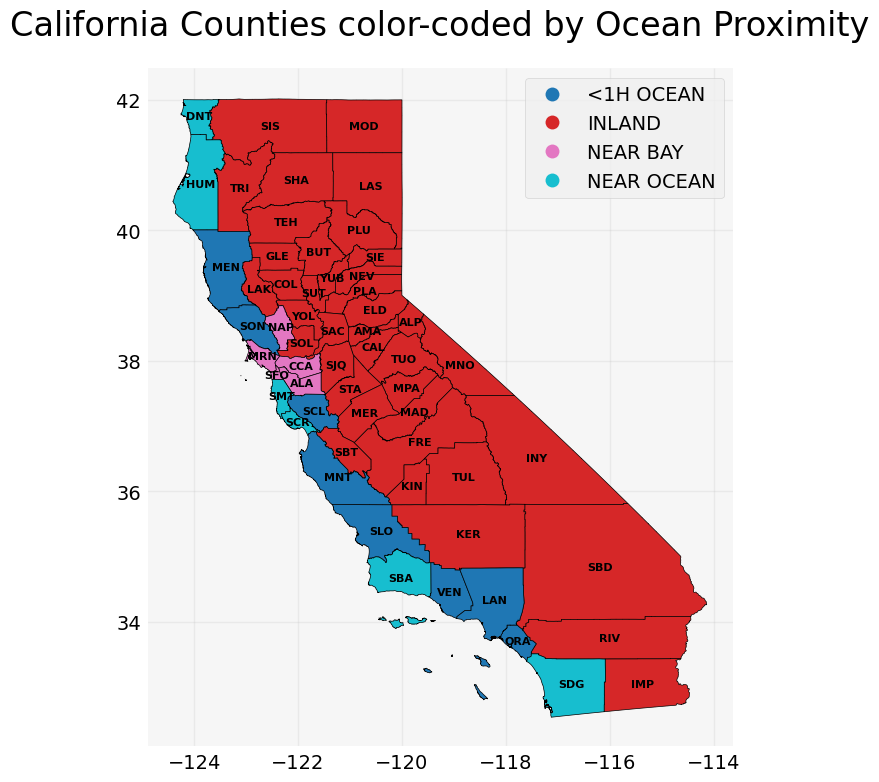

In [ ]:
plot_county_map(
    gdf_counties_median,
    show_scatter=False,
    show_abbrev=True,
    fig_title="California Counties color-coded by Ocean Proximity",
    gdf_counties_plot_kw={
        "column": "ocean_proximity",
        "legend": True,
    },
)

Moving on, we can check the most common income category in each county. We can clearly see that the categories change across counties. It makes sense since they were created considering the median income and location.

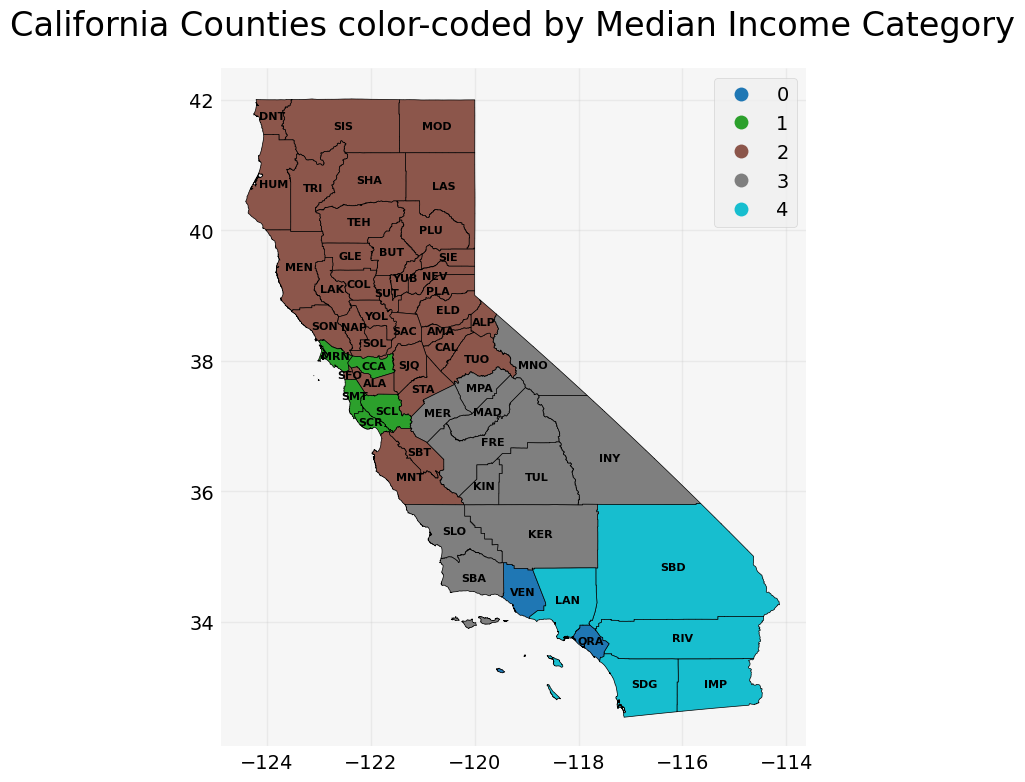

In [ ]:
plot_county_map(
    gdf_counties_median,
    show_scatter=False,
    show_abbrev=True,
    fig_title="California Counties color-coded by Median Income Category",
    gdf_counties_plot_kw={
        "column": "median_income_cat",
        "legend": True,
    },
)

We expect that house values will be highly correlated with income. Let's plot them side by side.

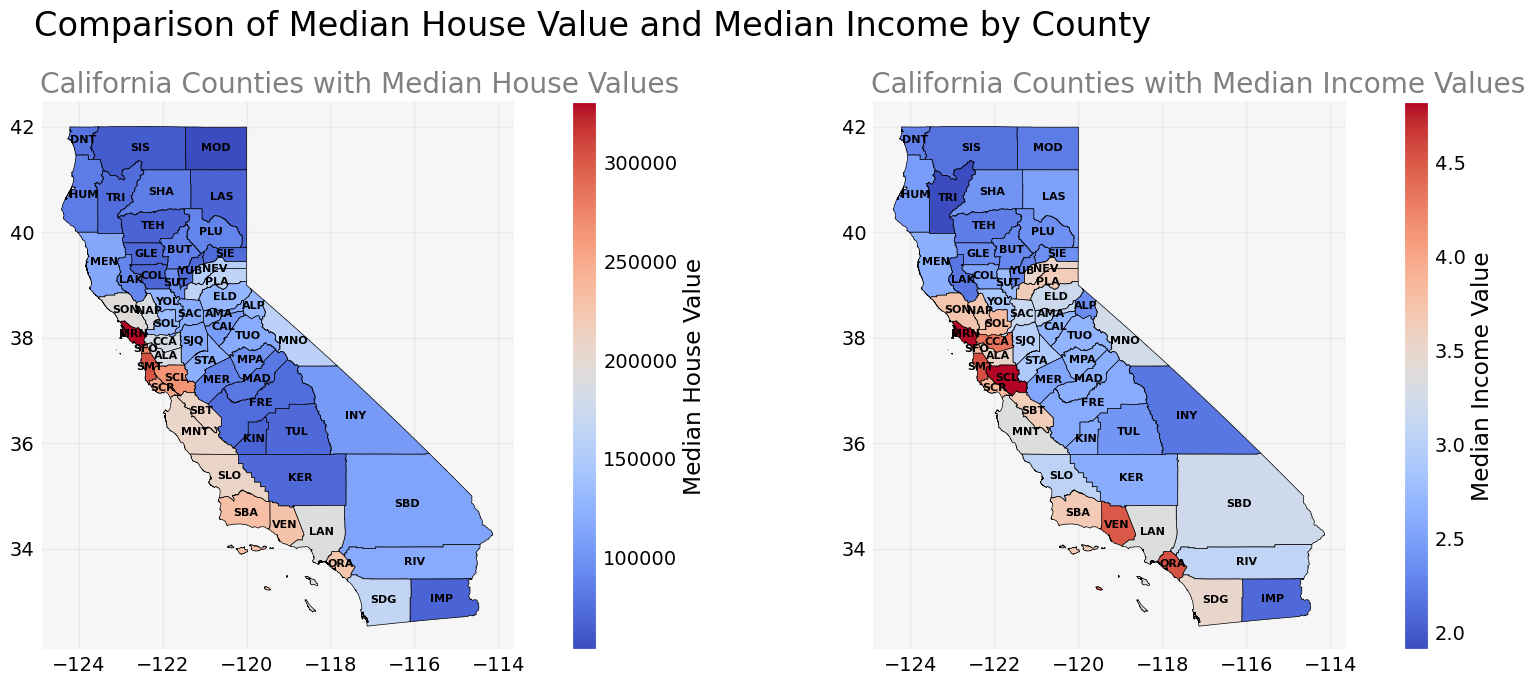

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(20, 7))

plot_county_map(
    gdf_counties_median,
    show_scatter=False,
    show_abbrev=True,
    fig_title="California Counties with Median House Values",
    gdf_counties_plot_kw={
        "column": "median_house_value",
        "cmap": "coolwarm",
        "legend": True,
        "legend_kwds": {
            "label": "Median House Value",
            "orientation": "vertical",
        },
    },
    axis=axs[0],
)

plot_county_map(
    gdf_counties_median,
    show_scatter=False,
    show_abbrev=True,
    fig_title="California Counties with Median Income Values",
    gdf_counties_plot_kw={
        "column": "median_income",
        "cmap": "coolwarm",
        "legend": True,
        "legend_kwds": {
            "label": "Median Income Value",
            "orientation": "vertical",
        },
    },
    axis=axs[1],
)

fig.suptitle(
    "Comparison of Median House Value and Median Income by County",
)

plt.show()

Finally, let's save the enriched dataset to a new Parquet file for further analysis or modeling. This file will contain both the original housing data and the county information, ready for geographic visualizations or location-aware machine learning tasks.


In [39]:
gdf_counties_median.to_parquet(GEO_MEDIAN_DF_FILE)